<a href="https://colab.research.google.com/github/k1994a/dsc-mod-4-project-v2-1-online-ds-sp-000/blob/master/student_final_colab_linked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Project Submission

* Student name: Kiarash Ahmadi
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name: Jeff Herman
* Blog post URL: https://kahmadi94.medium.com/solidifying-my-knowledge-of-convolutional-neural-networks-576fa9e9730b

# Introduction:

This project consisted of obtaining a set of images that consist of chest X-rays of patients with and without pneumonia and building a classifier using these images in order to be able to accurately detect pneumonia when given a chest X-ray. This problem is applicable to the real world in that it will help radiologists in ensuring they are accurately diagnosing patients. The classifier is built via a convolutional neural network where the training, validation, and testing sets of images are already determined given the dataset from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The outline of the images can be seen below:

- Number of Images in Training set with Pneumonia: 3875
- Number of Images in Training set without Pneumonia: 1341
- Number of Images in Testing set with Pneumonia: 390
- Number of Images in Testing set without Pneumonia: 234
- Number of Images in Validation set with Pneumonia: 8
- Number of Images in Validation set without Pneumonia: 8

From here, different configurations of convolutional neural networks are trained in an iterative process where its accuracy is evaluated in order to find the convolutional neural network that leads to the most accurate results.

# Imports

First, import the necessary packages for this project.

In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
import os
os.chdir('/gdrive')

In [ ]:
os.getcwd()

'/gdrive'

In [83]:
import numpy as np
np.random.seed(123)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from keras import optimizers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics


ModuleNotFoundError: ignored

# Data Preprocessing and Exploration

First let's access the dataset and ensure that the number of images in each set is correct.

In [ ]:
path_train_pneumonia = 'MyDrive/chest_xray/train/PNEUMONIA'
path_train_normal = 'MyDrive/chest_xray/train/NORMAL'
path_test_pneumonia = 'MyDrive/chest_xray/test/PNEUMONIA'
path_test_normal = 'MyDrive/chest_xray/test/NORMAL'
path_val_pneumonia = 'MyDrive/chest_xray/val/PNEUMONIA'
path_val_normal = 'MyDrive/chest_xray/val/NORMAL'

print('Number of Images in Training set with Pneumonia:',len([f for f in os.listdir(path_train_pneumonia) if not f.startswith('.')]))
print('Number of Images in Training set without Pneumonia:', len([f for f in os.listdir(path_train_normal) if not f.startswith('.')]))
print('Number of Images in Testing set with Pneumonia:', len([f for f in os.listdir(path_test_pneumonia) if not f.startswith('.')]))
print('Number of Images in Testing set without Pneumonia:', len([f for f in os.listdir(path_test_normal) if not f.startswith('.')]))
print('Number of Images in Validation set with Pneumonia:', len([f for f in os.listdir(path_val_pneumonia) if not f.startswith('.')]))
print('Number of Images in Validation set without Pneumonia:', len([f for f in os.listdir(path_val_normal) if not f.startswith('.')]))

Number of Images in Training set with Pneumonia: 3875
Number of Images in Training set without Pneumonia: 1341
Number of Images in Testing set with Pneumonia: 390
Number of Images in Testing set without Pneumonia: 234
Number of Images in Validation set with Pneumonia: 8
Number of Images in Validation set without Pneumonia: 8


From there, let's use the ImageDataGenerator to create the training, testing, and validation sets. At this point, I chose to resize the images to 128 x 128 pixels in hopes account for noise within the images. 

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    'MyDrive/chest_xray/train',
                                                     target_size=(128, 128),
                                                     batch_size= 5216,
                                                     class_mode='binary',
                                                     seed=123)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                   'MyDrive/chest_xray/test',
                                                     target_size=(128, 128),
                                                     batch_size=624,
                                                     class_mode='binary',
                                                     seed=123)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    'MyDrive/chest_xray/val',
                                                     target_size=(128, 128),
                                                     batch_size=16,
                                                     class_mode='binary',
                                                     seed=123) 

X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let's next check which class equates to Normal and which class equates to Pneumonia in addition to checking the shape on our training, validation, and testing sets to ensure the numbers are correct.

In [ ]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5216, 128, 128, 3)
(624, 128, 128, 3)
(16, 128, 128, 3)


Let's next view two images where one is a normal chest X-ray and the other is with pneumonia to get an idea of the differences between the two and to further confirm the class designations. 

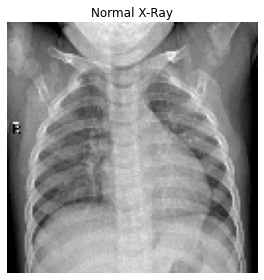

The class designation for the above image is 0


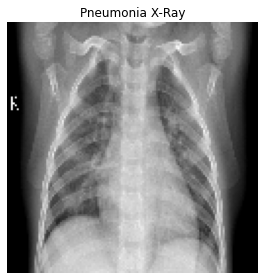

The class designation for the above image is 1


In [ ]:
plt.imshow(np.squeeze(X_train[0]))
plt.axis('off')
plt.title('Normal X-Ray')
plt.tight_layout()
plt.show()
# Check the class label ('Normal':0)
print(f'The class designation for the above image is {int(y_train[0])}')

plt.imshow(np.squeeze(X_train[1]))
plt.axis('off')
plt.title('Pneumonia X-Ray')
plt.tight_layout()
plt.show()
# Check class label ('Pneumonia':1)
print(f'The class designation for the above image is {int(y_train[1])}')

As it is often the case when building a classifier, the training data will have some class imbalance. Let's first evaluate to see if this is the case via a distribution plot as seen below.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


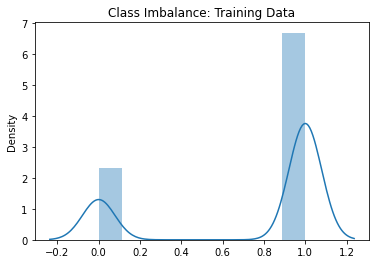

In [ ]:
sns.distplot(y_train)
plt.title('Class Imbalance: Training Data')
plt.show()

This does seem be the case in our training dataset and thus to account for this let's use the compute_class_weight function from sklearn in hopes to implement class weights when making our convolutional nueral networks.

In [ ]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights_dict = dict(zip(np.unique(y_train), weights))

Now let's define a variable named "input_image_size" to use during our construction of convolutional neural networks.

In [ ]:
input_image_size = X_test[0].shape
input_image_size

(128, 128, 3)

We are almost ready to start building our convolutional neural networks! However, we first need to set up a few more things before that. Let's first set up a list that defines the metrics that the neural network will be evaluating. The following metrics will be used while developing the network. 

- Accuracy: Whether the model predicts the right class or not for each image
- Precision: The accuracy of positive predictions. Calculated by dividing the number of true positives by the sum of the true positives and false positives.
- Recall: The percentage of positives that were correctly classified. Calculated by dividing the number of true positives by the sum of the true positives and false negatives

All 3 of these metrics were used in evaluating the convolutional neural networks because of the fact that a false positive would lead to a patient obtaining medicine that their body does not need. A false negative is equally if not more harmful as we do not want to misclassify a patient who has pneumonia. 

In [ ]:
mod_metrics = ['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')]

Let's next create a function that evaluates the results that come after training and fitting a model. This function will create 2 plots that visualize the accuracy and loss over time as well as create a confusion matrix, classification report, and the testing accuracy and loss. 

In [ ]:
def evaluate_results(results, y_test=y_test):

    history = results.history
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    y_pred = results.model.predict(X_test).round()
    y_true = y_test.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.xlim(-0.5, 2)
    plt.ylim(2, -0.5)
    plt.title('Model Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n')

    test_loss, test_acc, precision, recall = results.model.evaluate(X_test, y_test)
    print(f'Testing Set Loss: {test_loss}')
    print(f'Testing Set Accuracy: {test_acc}')
    
    

We are now ready to start building our convolutional neural networks! Let's first start out with 3 baseline models that will help decide which optimizer to use going forward. While this isn't the best process in that one should test different optimizers at each iteration of convolutional neural networks, it will help pick a standard optimizer to use going forward.

# Iteration #1: Baseline Models 

In [ ]:

cnn_baseline_adam = models.Sequential()

cnn_baseline_adam.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn_baseline_adam.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_adam.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn_baseline_adam.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_adam.add(Flatten())

cnn_baseline_adam.add(Dense(units = 128, activation = 'relu'))
cnn_baseline_adam.add(Dense(units = 1, activation = 'sigmoid'))

cnn_baseline_adam.compile(optimizer= 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

cnn_baseline_adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
history_baseline_adam = cnn_baseline_adam.fit(X_train,
                       y_train,
                       epochs=30, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 39s 80ms/step - loss: 0.3270 - accuracy: 0.8612 - precision: 0.8840 - recall: 0.9360 - val_loss: 0.5993 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 6s 68ms/step - loss: 0.1048 - accuracy: 0.9622 - precision: 0.9718 - recall: 0.9775 - val_loss: 0.7530 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 6s 67ms/step - loss: 0.0891 - accuracy: 0.9661 - precision: 0.9765 - recall: 0.9778 - val_loss: 0.7586 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 5s 67ms/step - loss: 0.0830 - accuracy: 0.9672 - precision: 0.9751 - recall: 0.9809 - val_loss: 0.3442 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 5s 66ms/step - loss: 0.0576 - accuracy: 0.9810 - precis

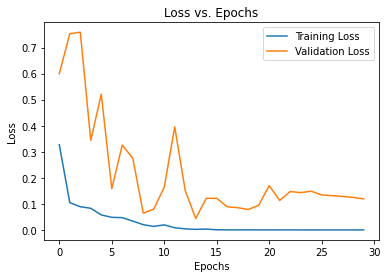

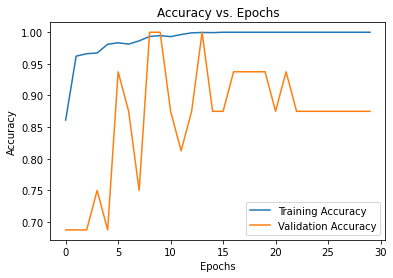

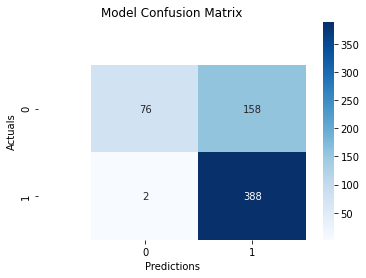

              precision    recall  f1-score   support

           0       0.97      0.32      0.49       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



20/20 [==============================] - 0s 12ms/step - loss: 3.8540 - accuracy: 0.7436 - precision: 0.7106 - recall: 0.9949
Testing Set Loss: 3.8540492057800293
Testing Set Accuracy: 0.7435897588729858


In [ ]:
evaluate_results(history_baseline_adam)

In [ ]:
cnn_baseline_rms = models.Sequential()

cnn_baseline_rms.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn_baseline_rms.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_rms.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn_baseline_rms.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_rms.add(Flatten())

cnn_baseline_rms.add(Dense(units = 128, activation = 'relu'))
cnn_baseline_rms.add(Dense(units = 1, activation = 'sigmoid'))

cnn_baseline_rms.compile(optimizer= 'RMSprop', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

cnn_baseline_rms.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
history_baseline_rms = cnn_baseline_rms.fit(X_train,
                       y_train,
                       epochs=50, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 7s 71ms/step - loss: 0.8091 - accuracy: 0.7816 - precision: 0.8072 - recall: 0.9137 - val_loss: 0.6333 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 6s 68ms/step - loss: 0.2469 - accuracy: 0.9120 - precision: 0.9382 - recall: 0.9437 - val_loss: 1.3942 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 6s 67ms/step - loss: 0.2053 - accuracy: 0.9268 - precision: 0.9443 - recall: 0.9579 - val_loss: 0.5383 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 5s 67ms/step - loss: 0.1473 - accuracy: 0.9473 - precision: 0.9637 - recall: 0.9654 - val_loss: 0.2923 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 6s 67ms/step - loss: 0.0988 - accuracy: 0.9645 - precisi

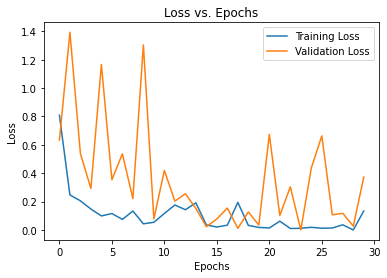

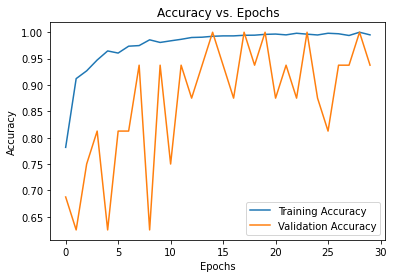

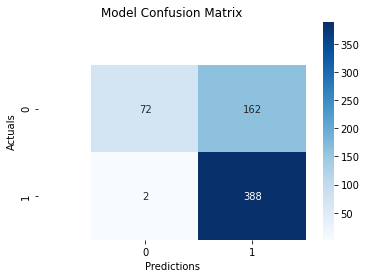

              precision    recall  f1-score   support

           0       0.97      0.31      0.47       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624



20/20 [==============================] - 0s 11ms/step - loss: 5.1243 - accuracy: 0.7372 - precision: 0.7055 - recall: 0.9949
Testing Set Loss: 5.1243109703063965
Testing Set Accuracy: 0.7371794581413269


In [ ]:
evaluate_results(history_baseline_rms)

In [ ]:
cnn_baseline_sgd = models.Sequential()

cnn_baseline_sgd.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn_baseline_sgd.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_sgd.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn_baseline_sgd.add(MaxPooling2D(pool_size = (2, 2)))

cnn_baseline_sgd.add(Flatten())

cnn_baseline_sgd.add(Dense(units = 128, activation = 'relu'))
cnn_baseline_sgd.add(Dense(units = 1, activation = 'sigmoid'))

cnn_baseline_sgd.compile(optimizer= 'SGD', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

cnn_baseline_sgd.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
history_baseline_sgd = cnn_baseline_sgd.fit(X_train,
                       y_train,
                       epochs=50, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 7s 72ms/step - loss: 0.5203 - accuracy: 0.7651 - precision: 0.7614 - recall: 0.9822 - val_loss: 0.9646 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 5s 66ms/step - loss: 0.4020 - accuracy: 0.8238 - precision: 0.8440 - recall: 0.9357 - val_loss: 0.6673 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 5s 66ms/step - loss: 0.3020 - accuracy: 0.8767 - precision: 0.8971 - recall: 0.9422 - val_loss: 0.6992 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 5s 66ms/step - loss: 0.2461 - accuracy: 0.9041 - precision: 0.9233 - recall: 0.9499 - val_loss: 1.0157 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 5s 66ms/step - loss: 0.1939 - accuracy: 0.9218 - precisi

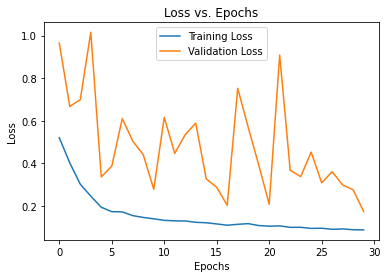

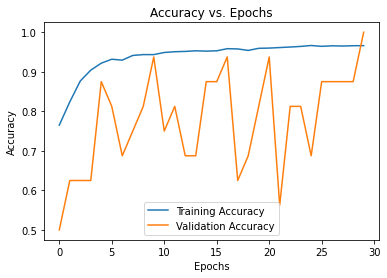

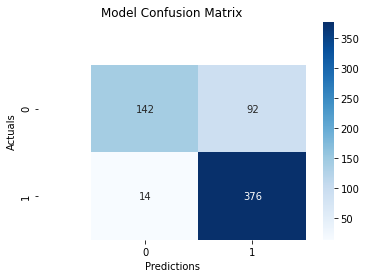

              precision    recall  f1-score   support

           0       0.91      0.61      0.73       234
           1       0.80      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



20/20 [==============================] - 0s 11ms/step - loss: 0.4879 - accuracy: 0.8301 - precision: 0.8034 - recall: 0.9641
Testing Set Loss: 0.48789000511169434
Testing Set Accuracy: 0.8301281929016113


In [ ]:
evaluate_results(history_baseline_sgd)

## Discussion

The accuracy of this model is not too bad especially the model that uses SGD as the optimizer. However, the number of false positives leaves a lot of room for improvement. Let's transition to making the next model have more layers and see the subsequent results.

# Iteration #2: Increase the number of layers

In [ ]:
model2 = models.Sequential()

model2.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Flatten())

model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dense(units = 1, activation = 'sigmoid'))


model2.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)             

In [ ]:
history2 = model2.fit(X_train,
                       y_train,
                       epochs=30, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 7s 72ms/step - loss: 0.5706 - accuracy: 0.7356 - precision: 0.7468 - recall: 0.9862 - val_loss: 0.7897 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 6s 67ms/step - loss: 0.5076 - accuracy: 0.7598 - precision: 0.7599 - recall: 0.9892 - val_loss: 0.9483 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 6s 67ms/step - loss: 0.4400 - accuracy: 0.7935 - precision: 0.8158 - recall: 0.9326 - val_loss: 0.6972 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 6s 67ms/step - loss: 0.3660 - accuracy: 0.8455 - precision: 0.8660 - recall: 0.9370 - val_loss: 0.8594 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 5s 67ms/step - loss: 0.3072 - accuracy: 0.8733 - precisi

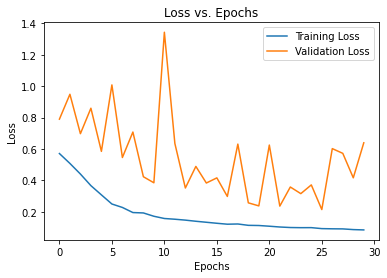

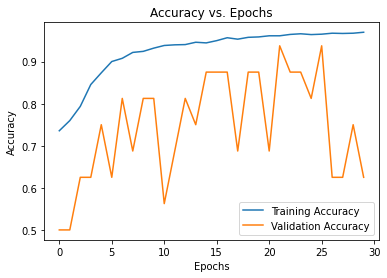

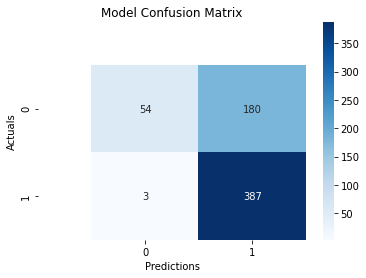

              precision    recall  f1-score   support

           0       0.95      0.23      0.37       234
           1       0.68      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.81      0.61      0.59       624
weighted avg       0.78      0.71      0.64       624



20/20 [==============================] - 0s 11ms/step - loss: 1.2144 - accuracy: 0.7067 - precision: 0.6825 - recall: 0.9923
Testing Set Loss: 1.214368462562561
Testing Set Accuracy: 0.7067307829856873


In [ ]:
evaluate_results(history2)

## Discussion

The accuracy of this model got worse as did the recall as seen by the increase in false positives. Thus, there is still a lot of room for improvement. Let's next decrease the dimensionality of the output space but keep the same architecture as the baseline model and evaluate the results.

# Iteration #3: Decrease Dimensionality

In [ ]:
model3 = models.Sequential()

model3.add(Conv2D(64, (3, 3), input_shape = input_image_size, activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(32, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Flatten())

model3.add(Dense(units = 128, activation = 'relu'))
model3.add(Dense(units = 1, activation = 'sigmoid'))

model3.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [ ]:
history3 = model3.fit(X_train,
                       y_train,
                       epochs=30, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 5s 42ms/step - loss: 0.5347 - accuracy: 0.7418 - precision: 0.7429 - recall: 0.9808 - val_loss: 0.6139 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 3s 35ms/step - loss: 0.4376 - accuracy: 0.8058 - precision: 0.8216 - recall: 0.9435 - val_loss: 0.9537 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 3s 35ms/step - loss: 0.3133 - accuracy: 0.8740 - precision: 0.8917 - recall: 0.9453 - val_loss: 0.7920 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 4/30
82/82 [==============================] - 3s 35ms/step - loss: 0.2604 - accuracy: 0.8965 - precision: 0.9174 - recall: 0.9458 - val_loss: 0.9822 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 3s 35ms/step - loss: 0.2031 - accuracy: 0.9199 - precisi

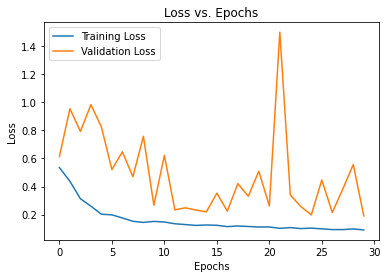

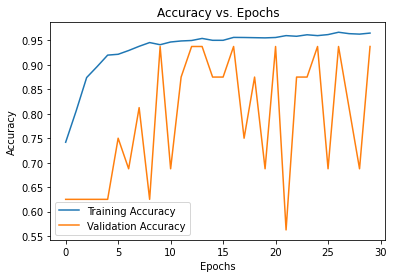

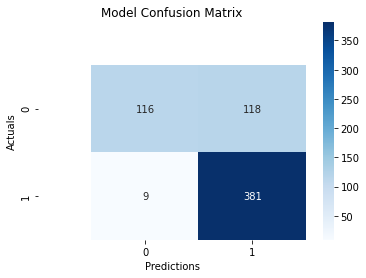

              precision    recall  f1-score   support

           0       0.93      0.50      0.65       234
           1       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



20/20 [==============================] - 0s 8ms/step - loss: 0.6413 - accuracy: 0.7965 - precision: 0.7635 - recall: 0.9769
Testing Set Loss: 0.6413305997848511
Testing Set Accuracy: 0.7964743375778198


In [ ]:
evaluate_results(history3)

## Discussion 

This produces worse results to the baseline model but better results than the deeper model that was anaylzed before which provides insight as to the impact of layer architecture vs. hyperparameters. Let's next deepen the convolutional neural network by adding more layers

# Iteration #4: Make the Neural Network Deeper

In [ ]:
model4 = models.Sequential()

model4.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(32, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Flatten())

model4.add(Dense(units = 128, activation = 'relu'))
model4.add(Dense(units = 1, activation = 'sigmoid'))


model4.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
    
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)             

In [ ]:
history4 = model4.fit(X_train,
                       y_train,
                       epochs=30, #change to larger later
                       batch_size=64,
                       validation_data=(X_val, y_val))

Epoch 1/30
82/82 [==============================] - 7s 71ms/step - loss: 0.5702 - accuracy: 0.7400 - precision: 0.7371 - recall: 0.9909 - val_loss: 0.7592 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 6s 67ms/step - loss: 0.5017 - accuracy: 0.7673 - precision: 0.7644 - recall: 0.9928 - val_loss: 1.4860 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 6s 68ms/step - loss: 0.4471 - accuracy: 0.7998 - precision: 0.8167 - recall: 0.9419 - val_loss: 0.7516 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 6s 67ms/step - loss: 0.3684 - accuracy: 0.8485 - precision: 0.8681 - recall: 0.9388 - val_loss: 1.2184 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 5s 67ms/step - loss: 0.3046 - accuracy: 0.8832 - precisi

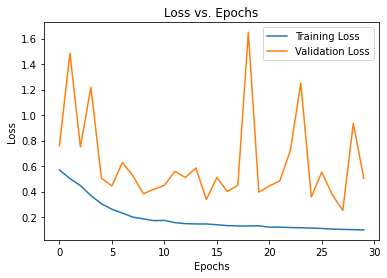

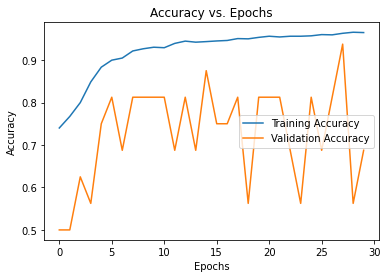

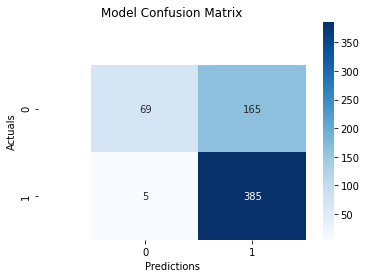

              precision    recall  f1-score   support

           0       0.93      0.29      0.45       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.73      0.68       624



20/20 [==============================] - 0s 11ms/step - loss: 1.0197 - accuracy: 0.7276 - precision: 0.7000 - recall: 0.9872
Testing Set Loss: 1.0196768045425415
Testing Set Accuracy: 0.7275640964508057


In [ ]:
evaluate_results(history4)

## Discussion

These results are our best so far. Let's next focus on our best model and look into altering the validation set by performing a validation split instead of using the validation data as it is only 16 total images.

# Iteration #5: Add More Images to the Validation Set

In [ ]:
model5 = models.Sequential()

model5.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2)))

model5.add(Conv2D(64, (3, 3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2)))

# model5.add(Conv2D(64, (3, 3), activation = 'relu'))
# model5.add(MaxPooling2D(pool_size = (2, 2)))

# model5.add(Conv2D(32, (3, 3), activation = 'relu'))
# model5.add(MaxPooling2D(pool_size = (2, 2)))

model5.add(Flatten())

model5.add(Dense(units = 128, activation = 'relu'))
model5.add(Dense(units = 1, activation = 'sigmoid'))


model5.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

model5.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [ ]:

history5 = model5.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                       validation_split = 0.2)

Epoch 1/30
66/66 [==============================] - 6s 82ms/step - loss: 0.5551 - accuracy: 0.7294 - precision: 0.7323 - recall: 0.9835 - val_loss: 0.4398 - val_accuracy: 0.7768 - val_precision: 0.7766 - val_recall: 1.0000
Epoch 2/30
66/66 [==============================] - 5s 70ms/step - loss: 0.4617 - accuracy: 0.7893 - precision: 0.8023 - recall: 0.9465 - val_loss: 0.5836 - val_accuracy: 0.7759 - val_precision: 0.7759 - val_recall: 1.0000
Epoch 3/30
66/66 [==============================] - 5s 71ms/step - loss: 0.3688 - accuracy: 0.8480 - precision: 0.8623 - recall: 0.9439 - val_loss: 0.3361 - val_accuracy: 0.8649 - val_precision: 0.9785 - val_recall: 0.8444
Epoch 4/30
66/66 [==============================] - 5s 70ms/step - loss: 0.3262 - accuracy: 0.8691 - precision: 0.8932 - recall: 0.9334 - val_loss: 0.2874 - val_accuracy: 0.8573 - val_precision: 0.8468 - val_recall: 0.9963
Epoch 5/30
66/66 [==============================] - 5s 70ms/step - loss: 0.2507 - accuracy: 0.8969 - precisi

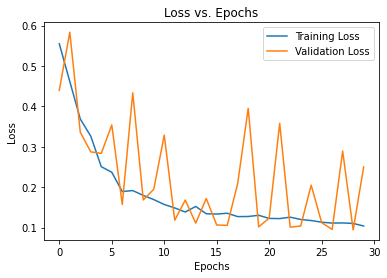

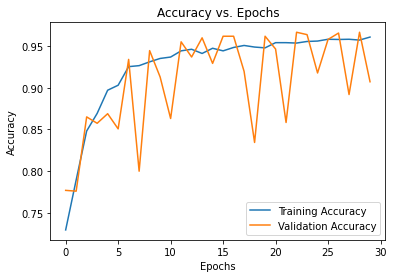

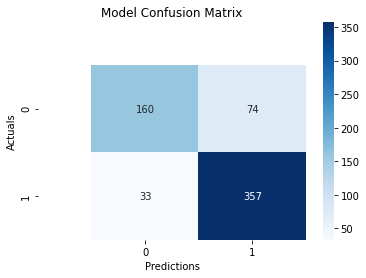

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       234
           1       0.83      0.92      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.80      0.81       624
weighted avg       0.83      0.83      0.82       624



20/20 [==============================] - 0s 11ms/step - loss: 0.4388 - accuracy: 0.8285 - precision: 0.8283 - recall: 0.9154
Testing Set Loss: 0.43884071707725525
Testing Set Accuracy: 0.8285256624221802


In [ ]:
evaluate_results(history5)

## Discussion 

Adding more images to the validation set actually made the testing accuracy slightly worse in terms of and improved the F1-score by decreasing the number of false positives. However, the number of false negatives increased. With all that said, this is our best model due to the slight decrease in testing accuracy and increase in F1-score. Let's next see implementing class weights onto the model affects the results. 

# Iteration #6: Adding Class Weights

In [ ]:
model6 = models.Sequential()

model6.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
model6.add(MaxPooling2D(pool_size = (2, 2)))

model6.add(Conv2D(64, (3, 3), activation = 'relu'))
model6.add(MaxPooling2D(pool_size = (2, 2)))

# model6.add(Conv2D(64, (3, 3), activation = 'relu'))
# model6.add(MaxPooling2D(pool_size = (2, 2)))

# model6.add(Conv2D(32, (3, 3), activation = 'relu'))
# model6.add(MaxPooling2D(pool_size = (2, 2)))

model6.add(Flatten())

model6.add(Dense(units = 128, activation = 'relu'))
model6.add(Dense(units = 1, activation = 'sigmoid'))


model6.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

model6.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [ ]:
history6 = model6.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_data=(X_val, y_val),
                        class_weight=weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
82/82 [==============================] - 6s 69ms/step - loss: 0.6280 - accuracy: 0.6252 - precision: 0.8372 - recall: 0.6413 - val_loss: 0.6256 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 2/30
82/82 [==============================] - 5s 65ms/step - loss: 0.4649 - accuracy: 0.8050 - precision: 0.9238 - recall: 0.8039 - val_loss: 0.5544 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 3/30
82/82 [==============================] - 5s 66ms/step - loss: 0.3396 - accuracy: 0.8577 - precision: 0.9485 - recall: 0.8550 - val_loss: 0.4006 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 5s 66ms/step - loss: 0.2619 - accuracy: 0.8886 - precision: 0.9580 - recall: 0.8890 - val_loss: 0.6882 - val_accuracy: 0.6250 - val_precision

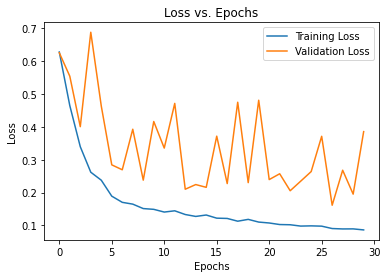

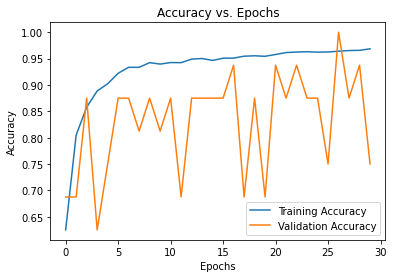

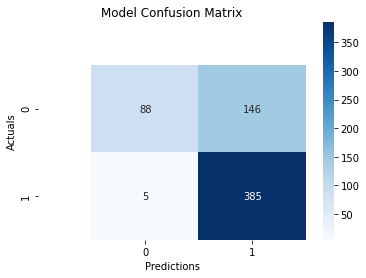

              precision    recall  f1-score   support

           0       0.95      0.38      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.69       624
weighted avg       0.81      0.76      0.72       624



20/20 [==============================] - 0s 14ms/step - loss: 0.9409 - accuracy: 0.7580 - precision: 0.7250 - recall: 0.9872
Testing Set Loss: 0.9408696293830872
Testing Set Accuracy: 0.7580128312110901


In [ ]:
evaluate_results(history6)

## Discussion

These results of this iteration are worse than the base model (iteration #1 using SGD optimizer) used to analyze the current model in that the accuracy and F1-score are worse as this model has far more false positives. Let's next add more images to the validation set and implement class weights. 

# Iteration #7: Increasing Validation Set and Adding Class Weights

In [ ]:
model7 = models.Sequential()

model7.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
model7.add(MaxPooling2D(pool_size = (2, 2)))

model7.add(Conv2D(64, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(pool_size = (2, 2)))

# model7.add(Conv2D(64, (3, 3), activation = 'relu'))
# model7.add(MaxPooling2D(pool_size = (2, 2)))

# model7.add(Conv2D(32, (3, 3), activation = 'relu'))
# model7.add(MaxPooling2D(pool_size = (2, 2)))

model7.add(Flatten())

model7.add(Dense(units = 128, activation = 'relu'))
model7.add(Dense(units = 1, activation = 'sigmoid'))


model7.compile(optimizer= 'sgd', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

model7.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [ ]:
history7 = model7.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_split= .2,
                        class_weight=weights_dict)

Epoch 1/30
66/66 [==============================] - 6s 74ms/step - loss: 0.6508 - accuracy: 0.5587 - precision: 0.8459 - recall: 0.5178 - val_loss: 0.5077 - val_accuracy: 0.7759 - val_precision: 0.7759 - val_recall: 1.0000
Epoch 2/30
66/66 [==============================] - 5s 70ms/step - loss: 0.5586 - accuracy: 0.7267 - precision: 0.8892 - recall: 0.7175 - val_loss: 0.5874 - val_accuracy: 0.6667 - val_precision: 0.9957 - val_recall: 0.5728
Epoch 3/30
66/66 [==============================] - 5s 71ms/step - loss: 0.4081 - accuracy: 0.8070 - precision: 0.9303 - recall: 0.7971 - val_loss: 0.2432 - val_accuracy: 0.9013 - val_precision: 0.8923 - val_recall: 0.9926
Epoch 4/30
66/66 [==============================] - 5s 70ms/step - loss: 0.3204 - accuracy: 0.8643 - precision: 0.9522 - recall: 0.8584 - val_loss: 0.1906 - val_accuracy: 0.9330 - val_precision: 0.9684 - val_recall: 0.9444
Epoch 5/30
66/66 [==============================] - 5s 70ms/step - loss: 0.2706 - accuracy: 0.8881 - precisi

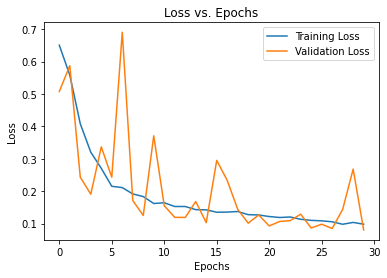

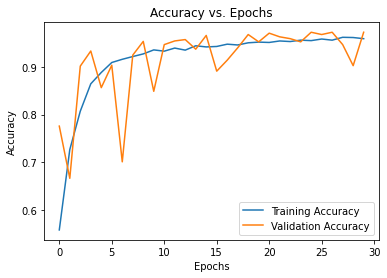

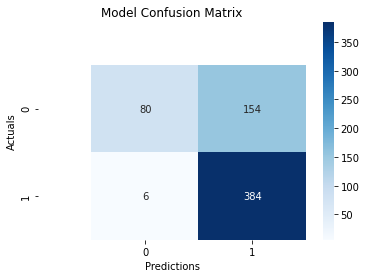

              precision    recall  f1-score   support

           0       0.93      0.34      0.50       234
           1       0.71      0.98      0.83       390

    accuracy                           0.74       624
   macro avg       0.82      0.66      0.66       624
weighted avg       0.79      0.74      0.70       624



20/20 [==============================] - 0s 11ms/step - loss: 0.9196 - accuracy: 0.7436 - precision: 0.7138 - recall: 0.9846
Testing Set Loss: 0.9195881485939026
Testing Set Accuracy: 0.7435897588729858


In [ ]:
evaluate_results(history7)

## Discussion 

These results are worse than the orginal model in terms of accuracy and F1-score. This specific neural net architecture has been exhausted. Let's next introduce a new architecture that is deeper than any current one we have created and then implement the same concepts of introducing class weights and a larger validation set.

# Iteration #8: New Architecture

In [65]:
model8 = models.Sequential()

model8.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model8.add(Conv2D(32, (3, 3), activation='relu'))
model8.add(MaxPooling2D((2, 2)))

model8.add(Conv2D(32, (3, 3), activation='relu'))
model8.add(Conv2D(32, (3, 3), activation='relu'))
model8.add(MaxPooling2D(2, 2))

model8.add(Conv2D(64, (3, 3), activation='relu'))
model8.add(Conv2D(64, (3, 3), activation='relu'))
model8.add(MaxPooling2D((2, 2)))

model8.add(Conv2D(64, (3, 3), activation='relu'))
model8.add(Conv2D(64, (3, 3), activation='relu'))
model8.add(MaxPooling2D((2, 2)))

model8.add(Flatten())
model8.add(Dense(128, activation='relu'))
model8.add(Dense(64, activation='relu'))
model8.add(Dense(1, activation='sigmoid'))

model8.compile(loss='binary_crossentropy',
                optimizer='adam', # used SGD and RMSprop here
                metrics= mod_metrics)
model8.summary()



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 27, 27, 64)      

In [66]:
history8 = model8.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_data= (X_val, y_val))

Epoch 1/30
82/82 [==============================] - 4s 37ms/step - loss: 0.5089 - accuracy: 0.7696 - precision: 0.7692 - recall: 0.9770 - val_loss: 0.7831 - val_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.8750
Epoch 2/30
82/82 [==============================] - 3s 33ms/step - loss: 0.2721 - accuracy: 0.8859 - precision: 0.9156 - recall: 0.9324 - val_loss: 0.6600 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
82/82 [==============================] - 3s 32ms/step - loss: 0.1768 - accuracy: 0.9271 - precision: 0.9457 - recall: 0.9569 - val_loss: 0.5236 - val_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 4/30
82/82 [==============================] - 3s 33ms/step - loss: 0.1356 - accuracy: 0.9467 - precision: 0.9656 - recall: 0.9626 - val_loss: 0.9433 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
82/82 [==============================] - 3s 33ms/step - loss: 0.1130 - accuracy: 0.9582 - precisi

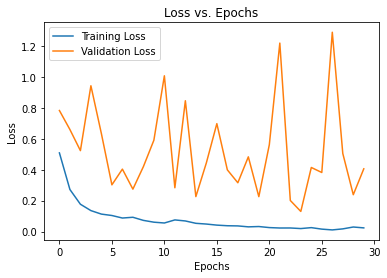

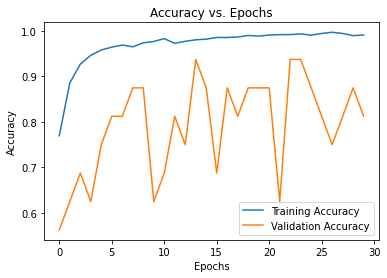

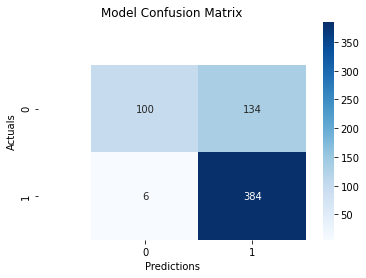

              precision    recall  f1-score   support

           0       0.94      0.43      0.59       234
           1       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



20/20 [==============================] - 0s 8ms/step - loss: 2.0011 - accuracy: 0.7756 - precision: 0.7413 - recall: 0.9846
Testing Set Loss: 2.0010616779327393
Testing Set Accuracy: 0.7756410241127014


In [67]:
evaluate_results(history8)

## Discussion 

This model has produced very good initial results! Note that the optimizer that was used was "adam" as through various iterations for this specific architecture, it produced the best results. Going forward, it should be noted that the optimizer can change and the reasoning behind each change is due to several iterations where either adam, sgd, or RMSprop is selected. Let's next add class weights to the same model to see if that improves the model's results.

# Iteration #9: Adding Class Weights to New Architecture

In [47]:
model9 = models.Sequential()

model9.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(MaxPooling2D(2, 2))

model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(128, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Flatten())
model9.add(Dense(128, activation='relu'))
model9.add(Dense(64, activation='relu'))
model9.add(Dense(1, activation='sigmoid'))

model9.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics= mod_metrics)

model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 27, 27, 64)       

In [48]:
history9 = model9.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_data= (X_val, y_val),
                        class_weight=weights_dict)

Epoch 1/30
82/82 [==============================] - 4s 38ms/step - loss: 0.6512 - accuracy: 0.4969 - precision: 0.8191 - recall: 0.4553 - val_loss: 0.9980 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/30
82/82 [==============================] - 3s 34ms/step - loss: 0.3580 - accuracy: 0.8376 - precision: 0.9466 - recall: 0.8281 - val_loss: 0.7108 - val_accuracy: 0.6250 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 3/30
82/82 [==============================] - 3s 33ms/step - loss: 0.2250 - accuracy: 0.9118 - precision: 0.9708 - recall: 0.9086 - val_loss: 0.8520 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/30
82/82 [==============================] - 3s 33ms/step - loss: 0.1571 - accuracy: 0.9406 - precision: 0.9814 - recall: 0.9378 - val_loss: 0.3548 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 5/30
82/82 [==============================] - 3s 34ms/step - loss: 0.1725 - accuracy: 0.9348 - precisi

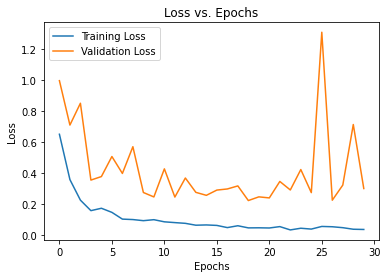

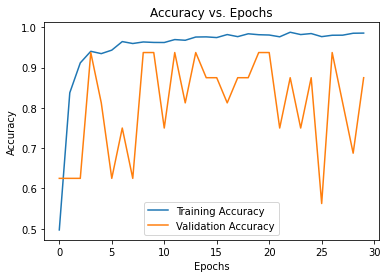

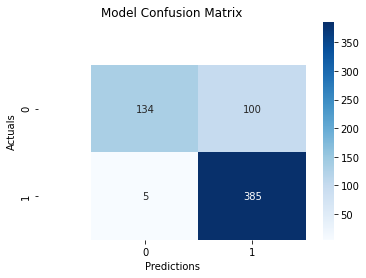

              precision    recall  f1-score   support

           0       0.96      0.57      0.72       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



20/20 [==============================] - 0s 7ms/step - loss: 1.0303 - accuracy: 0.8317 - precision: 0.7938 - recall: 0.9872
Testing Set Loss: 1.0302634239196777
Testing Set Accuracy: 0.8317307829856873


In [49]:
evaluate_results(history9)

In [ ]:
model9 = models.Sequential()

model9.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(Conv2D(32, (3, 3), activation='relu'))
model9.add(MaxPooling2D(2, 2))

model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Conv2D(128, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))

model9.add(Flatten())
model9.add(Dense(128, activation='relu'))
model9.add(Dense(64, activation='relu'))
model9.add(Dense(1, activation='sigmoid'))

model9.compile(loss='binary_crossentropy',
                optimizer='SGD',
                metrics= mod_metrics)

model9.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 27, 27, 64)      

In [ ]:
history9 = model9.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_data= (X_val, y_val),
                        class_weight=weights_dict)

Epoch 1/30
82/82 [==============================] - 6s 66ms/step - loss: 0.6929 - accuracy: 0.7055 - precision: 0.7428 - recall: 0.9109 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
82/82 [==============================] - 5s 60ms/step - loss: 0.6926 - accuracy: 0.4415 - precision: 0.8655 - recall: 0.2939 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
82/82 [==============================] - 5s 61ms/step - loss: 0.6924 - accuracy: 0.3234 - precision: 0.9139 - recall: 0.0986 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
82/82 [==============================] - 5s 60ms/step - loss: 0.6920 - accuracy: 0.3809 - precision: 0.9654 - recall: 0.1729 - val_loss: 0.6925 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 5/30
82/82 [==============================] - 5s 61ms/step - loss: 0.6917 - ac

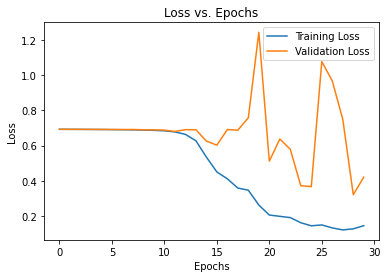

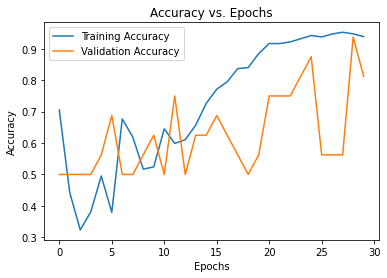

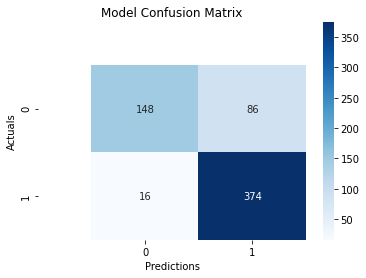

              precision    recall  f1-score   support

           0       0.90      0.63      0.74       234
           1       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.81       624
weighted avg       0.85      0.84      0.83       624



20/20 [==============================] - 0s 9ms/step - loss: 0.4471 - accuracy: 0.8365 - precision: 0.8130 - recall: 0.9590
Testing Set Loss: 0.44714438915252686
Testing Set Accuracy: 0.8365384340286255


In [ ]:
evaluate_results(history9)

## Discussion 

This even further improved our model's results! Let's next increase the size of the validation set but also maintain the use of class weights to see how this affects the model.

# Iteration #10: New Architecture with Larger Validation Split and Class Weights

In [ ]:
model10 = models.Sequential()

model10.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model10.add(Conv2D(32, (3, 3), activation='relu'))
model10.add(MaxPooling2D((2, 2)))

model10.add(Conv2D(32, (3, 3), activation='relu'))
model10.add(Conv2D(32, (3, 3), activation='relu'))
model10.add(MaxPooling2D(2, 2))

model10.add(Conv2D(64, (3, 3), activation='relu'))
model10.add(Conv2D(64, (3, 3), activation='relu'))
model10.add(MaxPooling2D((2, 2)))

model10.add(Conv2D(64, (3, 3), activation='relu'))
model10.add(Conv2D(64, (3, 3), activation='relu'))
model10.add(MaxPooling2D((2, 2)))

model10.add(Conv2D(128, (3, 3), activation='relu'))
model10.add(MaxPooling2D((2, 2)))

model10.add(Flatten())
model10.add(Dense(128, activation='relu'))
model10.add(Dense(64, activation='relu'))
model10.add(Dense(1, activation='sigmoid'))

model10.compile(loss='binary_crossentropy',
                optimizer='SGD',
                metrics= mod_metrics)

model10.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 27, 27, 64)      

In [ ]:
history10 = model10.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_split = .2,
                        class_weight=weights_dict)

Epoch 1/30
66/66 [==============================] - 6s 84ms/step - loss: 0.7000 - accuracy: 0.2790 - precision: 0.8075 - recall: 0.1311 - val_loss: 0.6992 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
66/66 [==============================] - 4s 64ms/step - loss: 0.6997 - accuracy: 0.2653 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6999 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
66/66 [==============================] - 4s 64ms/step - loss: 0.6995 - accuracy: 0.2653 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6987 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
66/66 [==============================] - 4s 65ms/step - loss: 0.6992 - accuracy: 0.2653 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6982 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
66/66 [==============================] - 

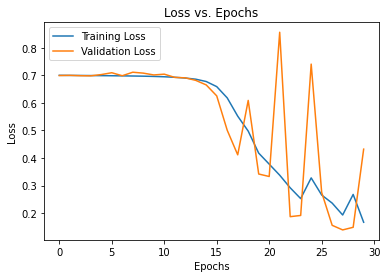

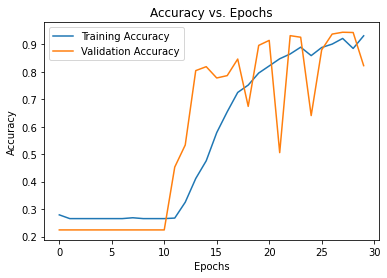

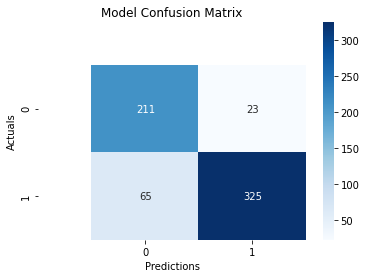

              precision    recall  f1-score   support

           0       0.76      0.90      0.83       234
           1       0.93      0.83      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.87      0.85       624
weighted avg       0.87      0.86      0.86       624



20/20 [==============================] - 0s 9ms/step - loss: 0.3597 - accuracy: 0.8590 - precision: 0.9339 - recall: 0.8333
Testing Set Loss: 0.3596745729446411
Testing Set Accuracy: 0.8589743375778198


In [ ]:
evaluate_results(history10)

## Discussion 

These results are better than using the initial validation set however the optimizer was changed as SGD performed best for this model. This is now our best model and this specific architecture has been exhausted (filter size and stride length was changed no improvements were made). Let's next focus on adding a pre-trained model and see if this can improve our results.

# Iteration #11: Using a Pretrained Network via Transfer Learning

Let's use the VGG19 pre-trained network. We will next add the pre-trained network to a model and then freeze the pretrained network so the information gain from the pre-trained network is not lost.

In [ ]:
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [ ]:
model11 = models.Sequential()
model11.add(cnn_base)
model11.add(Flatten())
model11.add(Dense(128, activation='relu'))
model11.add(Dense(64, activation='relu'))
model11.add(Dense(1, activation='sigmoid'))

In [ ]:
for layer in model11.layers:
    print(layer.name, layer.trainable)

print(len(model11.trainable_weights))

vgg19 True
flatten_16 True
dense_38 True
dense_39 True
dense_40 True
38


In [ ]:
cnn_base.trainable = False

In [ ]:
for layer in model11.layers:
    print(layer.name, layer.trainable)

print(len(model11.trainable_weights))

vgg19 False
flatten_16 True
dense_38 True
dense_39 True
dense_40 True
6


In [ ]:
model11.compile(loss='binary_crossentropy',
                optimizer='SGD',
                metrics= mod_metrics)

model11.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 21,081,409
Trainable params: 1,057,025
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history11 = model11.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=64,
                        validation_split = .2,
                        class_weight=weights_dict)

Epoch 1/30
66/66 [==============================] - 10s 134ms/step - loss: 0.5739 - accuracy: 0.6949 - precision: 0.8391 - recall: 0.7201 - val_loss: 0.9358 - val_accuracy: 0.4368 - val_precision: 1.0000 - val_recall: 0.2741
Epoch 2/30
66/66 [==============================] - 9s 131ms/step - loss: 0.3649 - accuracy: 0.8327 - precision: 0.9441 - recall: 0.8209 - val_loss: 0.2025 - val_accuracy: 0.9195 - val_precision: 0.9134 - val_recall: 0.9901
Epoch 3/30
66/66 [==============================] - 8s 128ms/step - loss: 0.2608 - accuracy: 0.8866 - precision: 0.9625 - recall: 0.8799 - val_loss: 0.9029 - val_accuracy: 0.6121 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 4/30
66/66 [==============================] - 8s 126ms/step - loss: 0.2482 - accuracy: 0.8943 - precision: 0.9659 - recall: 0.8874 - val_loss: 0.8302 - val_accuracy: 0.6609 - val_precision: 1.0000 - val_recall: 0.5630
Epoch 5/30
66/66 [==============================] - 8s 124ms/step - loss: 0.1925 - accuracy: 0.9185 - p

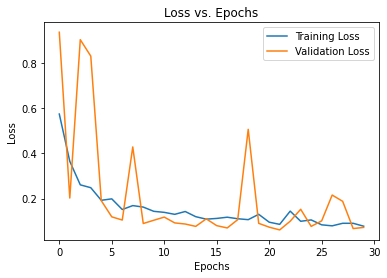

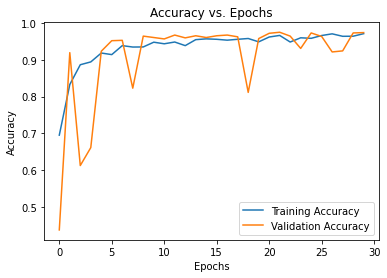

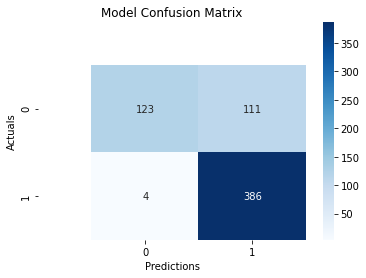

              precision    recall  f1-score   support

           0       0.97      0.53      0.68       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



20/20 [==============================] - 1s 50ms/step - loss: 0.5857 - accuracy: 0.8157 - precision: 0.7767 - recall: 0.9897
Testing Set Loss: 0.5856543779373169
Testing Set Accuracy: 0.8157051205635071


In [ ]:
evaluate_results(history11)

## Discussion 

This model's results are worse than our best model in that it has a lower testing set accuracy and lower precision and higher recall which in turn lead to a higher F1-score. Let's next take our best non pre-trained model and incorporate callbacks and dropout to see if it can help improve results.

# Iteration #12: Incorporate Dropout and Callbacks on Best Model

In [71]:
# Set up early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr_redox = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stop, lr_redox]

In [72]:
model12 = models.Sequential()

model12.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model12.add(Conv2D(32, (3, 3), activation='relu'))
model12.add(MaxPooling2D((2, 2)))
Dropout(.2)


model12.add(Conv2D(32, (3, 3), activation='relu'))
model12.add(Conv2D(32, (3, 3), activation='relu'))
model12.add(MaxPooling2D(2, 2))
Dropout(.2)


model12.add(Conv2D(64, (3, 3), activation='relu'))
model12.add(Conv2D(64, (3, 3), activation='relu'))
model12.add(MaxPooling2D((2, 2)))
model12.add(Dropout(.2))

model12.add(Conv2D(64, (3, 3), activation='relu'))
model12.add(Conv2D(64, (3, 3), activation='relu'))
model12.add(MaxPooling2D((2, 2)))
model12.add(Dropout(.2))


model12.add(Flatten())
model12.add(Dense(128, activation='relu'))
model12.add(Dropout(.2))

model12.add(Dense(64, activation='relu'))
model12.add(Dense(1, activation='sigmoid'))

model12.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics= mod_metrics)
model12.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 27, 27, 64)      

In [ ]:
history12 = model12.fit(X_train,
                       y_train,
                       epochs=150,
                        callbacks = callbacks,
                       batch_size=64,
                        validation_split = .2,
                        class_weight=weights_dict)

Epoch 1/150
66/66 [==============================] - 6s 71ms/step - loss: 0.6997 - accuracy: 0.2685 - precision: 0.9622 - recall: 0.1156 - val_loss: 0.7000 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
66/66 [==============================] - 4s 65ms/step - loss: 0.6990 - accuracy: 0.2658 - precision: 1.0000 - recall: 6.5253e-04 - val_loss: 0.7001 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
66/66 [==============================] - 4s 64ms/step - loss: 0.6986 - accuracy: 0.2677 - precision: 0.7778 - recall: 0.0046 - val_loss: 0.6947 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
66/66 [==============================] - 4s 65ms/step - loss: 0.6978 - accuracy: 0.2999 - precision: 0.9557 - recall: 0.0493 - val_loss: 0.6977 - val_accuracy: 0.2241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
66/66 [==============================] - 4s 64ms/step - 

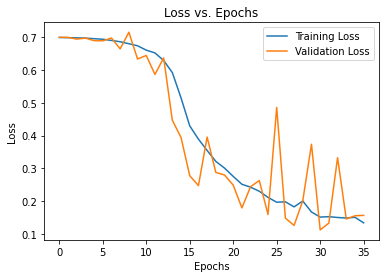

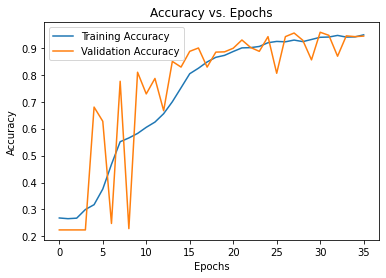

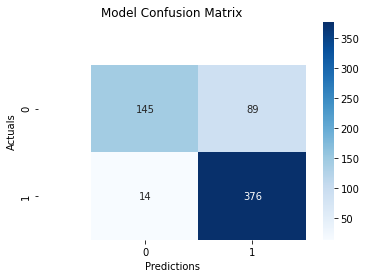

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       234
           1       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.83       624



20/20 [==============================] - 0s 13ms/step - loss: 0.4288 - accuracy: 0.8349 - precision: 0.8086 - recall: 0.9641
Testing Set Loss: 0.42878082394599915
Testing Set Accuracy: 0.8349359035491943


In [ ]:
evaluate_results(history12)

## Discussion 

This is one of our best models in the metrics we have been using to evaluate. It seems as though there is a tradeoff between models in that either there a lot of false positives or false negatives. Let's next evaluate models that take in training data that has been augmented. We first will set a file path and then augment the image. Notice that the images are not rotated as this was shown to alter the results drastically and recommended against for this specific problem.


# Iteration #13: Perform Image Augmentation

In [ ]:
path_train = 'MyDrive/chest_xray/train'


In [ ]:
train_datagen_aug = ImageDataGenerator(rescale=(1./255),
                                          zoom_range = 0.2,  
                                          width_shift_range=0.1,  
                                          height_shift_range=0.1,  
                                          brightness_range=[0.8,1.2])
train_data_aug = train_datagen_aug.flow_from_directory(path_train, 
                                                    target_size=(128,128),
                                                    batch_size=128 #use 5216 if you have time as it can crash the computer,   
                                                    class_mode='binary',
                                                    seed=123)

Found 5216 images belonging to 2 classes.


In [ ]:
model13 = models.Sequential()

model13.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model13.add(Conv2D(32, (3, 3), activation='relu'))
model13.add(MaxPooling2D((2, 2)))

model13.add(Conv2D(32, (3, 3), activation='relu'))
model13.add(Conv2D(32, (3, 3), activation='relu'))
model13.add(MaxPooling2D(2, 2))

model13.add(Conv2D(64, (3, 3), activation='relu'))
model13.add(Conv2D(64, (3, 3), activation='relu'))
model13.add(MaxPooling2D((2, 2)))

model13.add(Conv2D(64, (3, 3), activation='relu'))
model13.add(Conv2D(64, (3, 3), activation='relu'))
model13.add(MaxPooling2D((2, 2)))

model13.add(Flatten())
model13.add(Dense(128, activation='relu'))
model13.add(Dense(64, activation='relu'))
model13.add(Dense(1, activation='sigmoid'))

model13.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics= mod_metrics)
model13.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 64)       

discuss selection of RMSprop over SGD here.

In [ ]:
history13 = model13.fit(train_data_aug,
                       epochs=30,
                       batch_size=64,
                        validation_data= (X_val, y_val))

Epoch 1/30
41/41 [==============================] - 70s 2s/step - loss: 0.5727 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.9303 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
41/41 [==============================] - 69s 2s/step - loss: 0.5660 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.7844 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
41/41 [==============================] - 69s 2s/step - loss: 0.5567 - accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.6747 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
41/41 [==============================] - 69s 2s/step - loss: 0.4809 - accuracy: 0.7774 - precision: 0.7902 - recall: 0.9535 - val_loss: 0.6322 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/30
41/41 [==============================] - 69s 2s/step - loss: 0.3793 - accuracy: 0.8422 - precision: 0

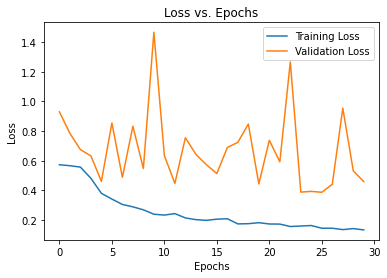

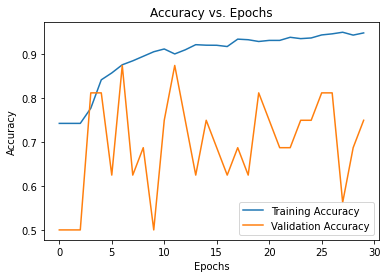

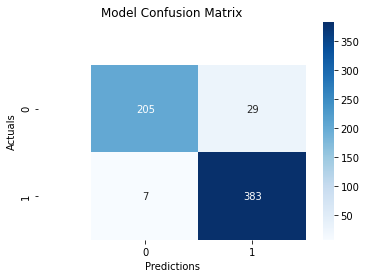

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       234
           1       0.93      0.98      0.96       390

    accuracy                           0.94       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.94      0.94      0.94       624



20/20 [==============================] - 0s 8ms/step - loss: 0.2076 - accuracy: 0.9423 - precision: 0.9296 - recall: 0.9821
Testing Set Loss: 0.20761440694332123
Testing Set Accuracy: 0.942307710647583


In [28]:
evaluate_results(history13)

## Discussion 

This is by far our best model! It outperforms every other model in every metric we have been evaluating. Also note that the optimizer "RMSprop" was used here it was found that it performed the best when training on the augmented data. Let's next see if we can even further improve these results by adding class weights. 

# Iteration #14: Implementing Class Weights on Augmented Data

In [29]:
model14 = models.Sequential()

model14.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_image_size))
model14.add(Conv2D(32, (3, 3), activation='relu'))
model14.add(MaxPooling2D((2, 2)))

model14.add(Conv2D(32, (3, 3), activation='relu'))
model14.add(Conv2D(32, (3, 3), activation='relu'))
model14.add(MaxPooling2D(2, 2))

model14.add(Conv2D(64, (3, 3), activation='relu'))
model14.add(Conv2D(64, (3, 3), activation='relu'))
model14.add(MaxPooling2D((2, 2)))

model14.add(Conv2D(64, (3, 3), activation='relu'))
model14.add(Conv2D(64, (3, 3), activation='relu'))
model14.add(MaxPooling2D((2, 2)))

model14.add(Flatten())
model14.add(Dense(128, activation='relu'))
model14.add(Dense(64, activation='relu'))
model14.add(Dense(1, activation='sigmoid'))

model14.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics= mod_metrics)
model14.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 27, 27, 64)       

In [30]:
history14 = model14.fit(train_data_aug,
                       epochs = 30,
                       batch_size=64,
                        validation_data= (X_val, y_val),
                    class_weight=weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
41/41 [==============================] - 73s 2s/step - loss: 0.6974 - accuracy: 0.4611 - precision: 0.7746 - recall: 0.4689 - val_loss: 0.6925 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
41/41 [==============================] - 71s 2s/step - loss: 0.7326 - accuracy: 0.5259 - precision: 0.7815 - recall: 0.5022 - val_loss: 0.6818 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
41/41 [==============================] - 71s 2s/step - loss: 0.6681 - accuracy: 0.6313 - precision: 0.8056 - recall: 0.6640 - val_loss: 0.8618 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
41/41 [==============================] - 70s 2s/step - loss: 0.6245 - accuracy: 0.6676 - precision: 0.8640 - recall: 0.6557 - val_loss: 0.4451 - val_accuracy: 0.

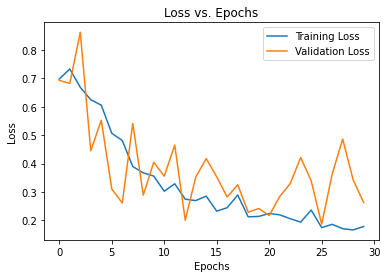

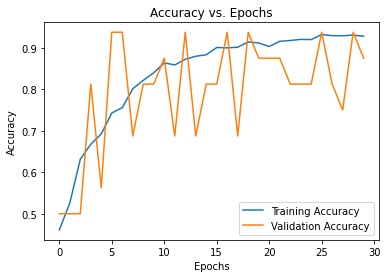

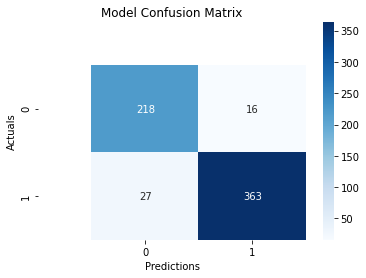

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       234
           1       0.96      0.93      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



20/20 [==============================] - 0s 8ms/step - loss: 0.1696 - accuracy: 0.9311 - precision: 0.9578 - recall: 0.9308
Testing Set Loss: 0.16960442066192627
Testing Set Accuracy: 0.9310897588729858


In [114]:
evaluate_results(history14)

## Discussion

This model performs slightly worse than the model in iteration #13 but they are very similar. The key deciding point in choosing iteration #13 as our best model is the fact that it has less false negatives and just an overall better score. When evaluating comparable models, the deciding factor should be the number of false negatives as this would be the most harmful outcome in real life if a patient with pneumonia were to not be diagnosed properly. We now have a very accurate model! Let's now analyze this model's performance via visualization of the activation functions and using a package called LIME to analyze how the model comes to it's decision when predicting classes.

# Visualization of Activation Functions

The following is code that helps us gain a better sense of what our CNN is using to train itself. This code essentially consists of visualizations of the feature maps generated by each layer during training. Thus, as we get deeper into the convolutional neural network, more filters are being applied and the feature map gets more abstract. Let's test this theory out and see if it is the case.

In [75]:
i = np.random.choice(range(len(y_val)))
label = y_val[i]
img = y_val[i]

# Format as 4D tensor for feature mapping
img_tensor = np.expand_dims(X_val[i], axis=0)
img_tensor.shape

(1, 128, 128, 3)

In [76]:
layer_outputs = [layer.output for layer in model13.layers[:12]]
layer_outputs
# Make a model to display the feature maps
activation_model = models.Model(inputs=model13.input, outputs=layer_outputs)

# Get feature maps for the layers
activations = activation_model.predict(img_tensor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


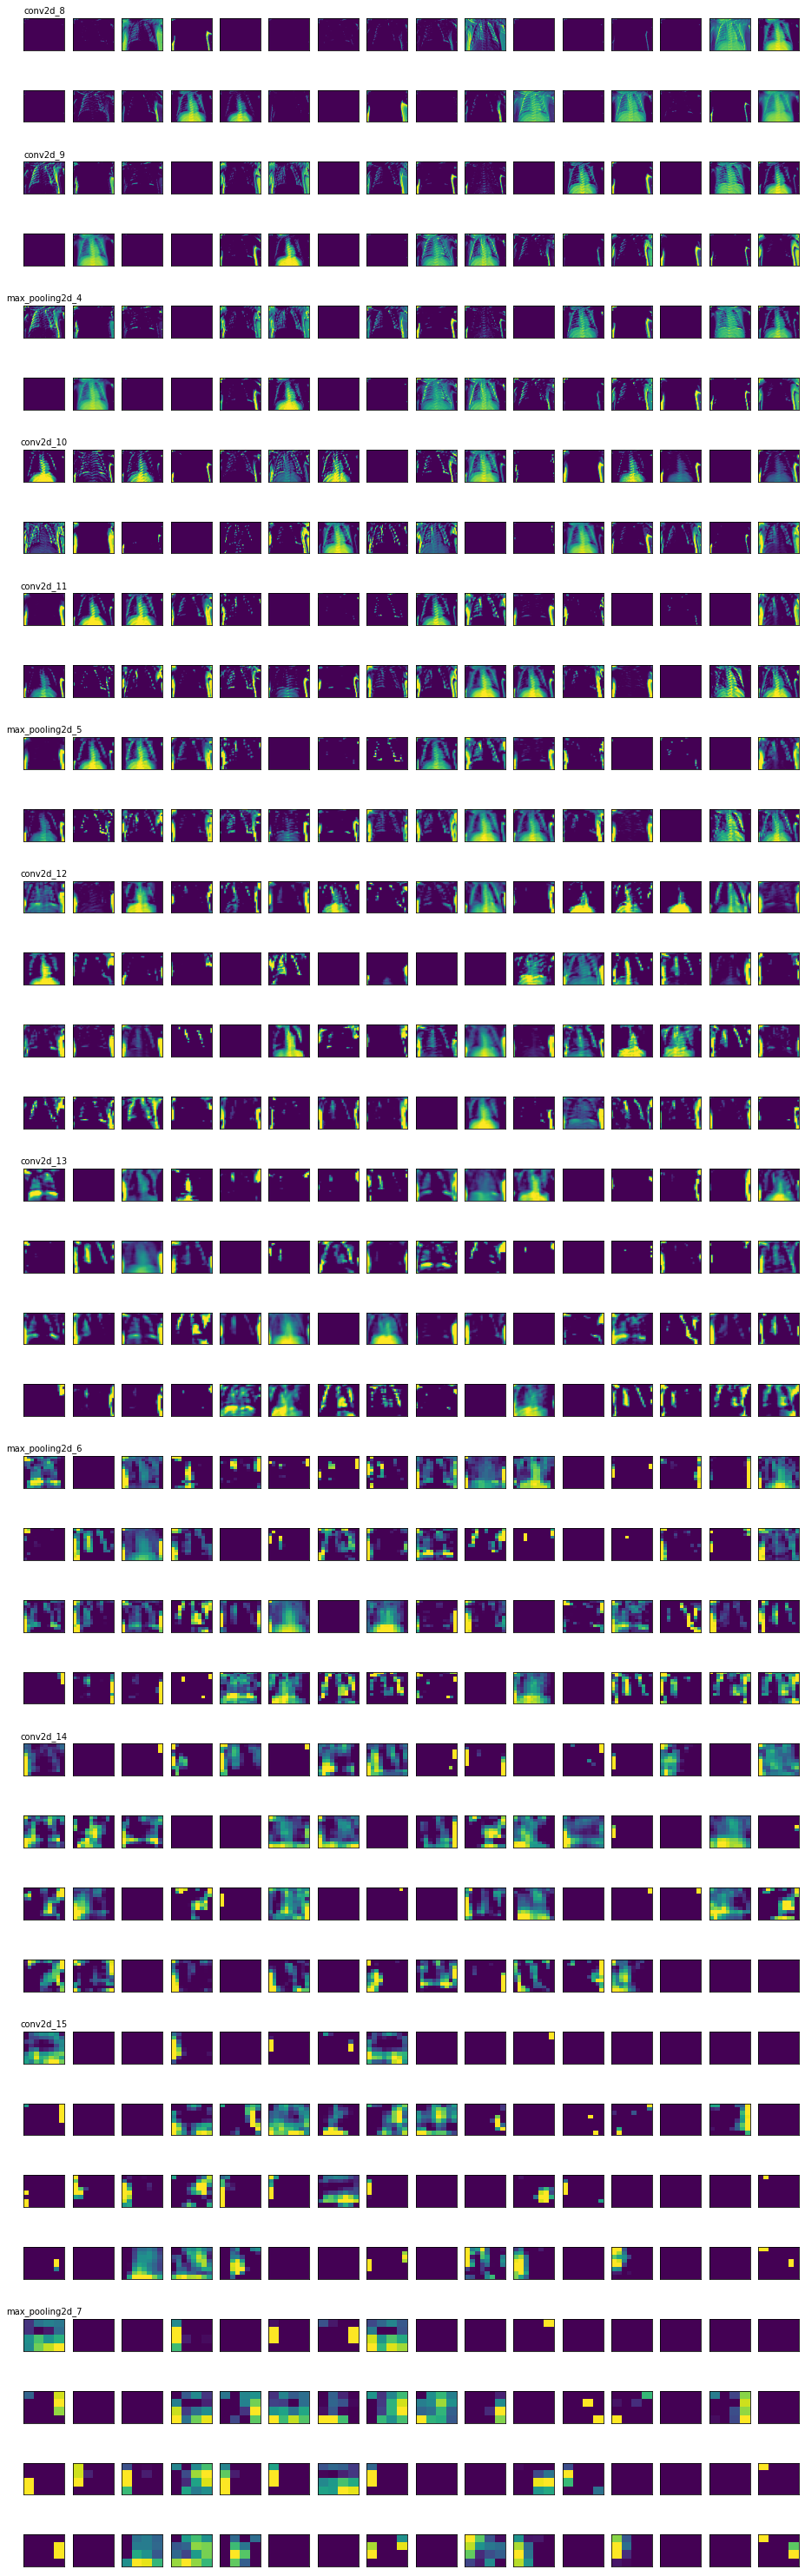

In [77]:
from keras import models
import math 

# Extract Layer Names for Labelling
layer_names = []
for layer in model13.layers[:12]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.show()

Notice that as you get deeper in the convolutional neural network, the visuals become more abstract and look more like blobs. This is a real time demenonstration of what the CNN is using at each layer to be trained on. Once these layers of abstraction are done, the output feature map is transformed to a 1-D vector and fed into a fully connected (dense) layer to then generate the final output which is the probability that an image is one class over the other.


# Analyzing Features that Lead to Classification via LIME

What we will do next is evaluate a random image to understand why it was classified by analyzing the key features that led to a class designation. This will be done using a package called lime so let's first install the package.  

In [85]:
pip install lime

     |████████████████████████████████| 276kB 4.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=3a9285b825a37a2af4319013731dc889b8f7faaa7fbbd1435c6cb93fe0a0d6a5
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [86]:
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

True Class: 1.0
Predicted Class: 1


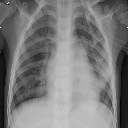

In [98]:
# Draw a random image from the training set
ndx = np.random.randint(0,5216)
label = y_train[ndx]
img = X_train[ndx]

# Predict the image class via the same method used before and visualize the image
pred = model13.predict(np.array([img]))
pred_class = int(pred.round())
print('True Class:', label)
print('Predicted Class:', pred_class)
array_to_img(img)

In [99]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model13.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)


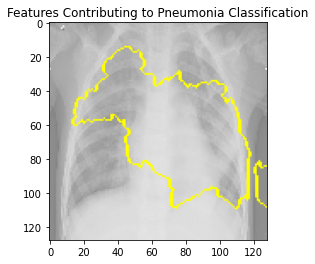

In [104]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
test = train_generator.class_indices
lookup = {value: key for key, value in test.items()}
name = lookup[label].lower().capitalize()
plt.title(f'Features Contributing to {name} Classification')
plt.show()

The highlighted area is the superpixels that positively contributed to the class designation. Thus, these key features are what led our best model to classify the image. This of course means there are superpixels that can negatively contribute to an image classfication as we will see below.

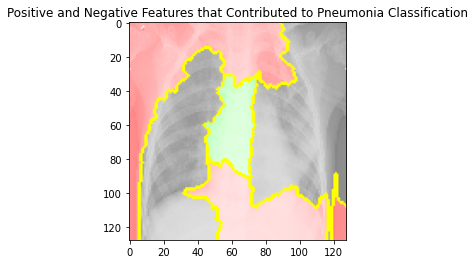

In [113]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only = False, num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
test = train_generator.class_indices
lookup = {value: key for key, value in test.items()}
name = lookup[label].lower().capitalize()
plt.title(f'Positive and Negative Features that Contributed to {name} Classification')
plt.show()

In this image the red spots equate to superpixels that negatively contributed to class designation whereas the green spots represent superpixels that positively contributed to the class designation. This exercise helps to understand the process behind image classification for our best model and is therefore worthwhile in further understanding convolutional neural networks.

# Conclusion

Our final model consisted of a deeper architecture that used augmented training data. This implementation of augmented training data is what changed the model's outcome drastically as it improved our metrics significantly. The metrics for our best model are:
- Testing Accuracy: 94.23%
- Testing Loss: 0.2076
- Recall: 0.94
- Precision: 0.94
- F1-Score: 0.94

These results are highly robust and thus the recommendations to medical professionals and data scientists who work in such a field would be:

- Downsize the image in order to reduce noise
- Continue to add more images to the training and validation set
- Use the model as one of many tools when diagnosing a chest X-ray as although it is accurate, nothing beats the opinion of a medical professional who is able to provide the science behind the distinguishing features in a chest X-ray.

Thus using convolutional neural networks in conjuction with the advice of a medical professional can minimize the chances that a patient is not properly diagnosed.

# Misc. code

In [74]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def build_clf(unit):
  cnn = models.Sequential()

  cnn.add(Conv2D(32, (3, 3), activation='relu',
                      input_shape=input_image_size))
  cnn.add(Conv2D(32, (3, 3), activation='relu'))
  cnn.add(MaxPooling2D((2, 2)))

  cnn.add(Conv2D(32, (3, 3), activation='relu'))
  cnn.add(Conv2D(32, (3, 3), activation='relu'))
  cnn.add(MaxPooling2D((2, 2)))

  cnn.add(Conv2D(64, (3, 3), activation='relu'))
  cnn.add(Conv2D(64, (3, 3), activation='relu'))
  cnn.add(MaxPooling2D((2, 2)))

  cnn.add(Conv2D(64, (3, 3), activation='relu'))
  cnn.add(Conv2D(64, (3, 3), activation='relu'))
  cnn.add(MaxPooling2D((2, 2)))

  cnn.add(Conv2D(128, (3, 3), activation='relu'))
  model15.add(MaxPooling2D((2, 2)))

  cnn.add(Flatten())
  cnn.add(Dense(128, activation='relu'))
  cnn.add(Dense(64, activation='relu'))
  cnn.add(Dense(1, activation='sigmoid'))

  cnn.compile(loss='binary_crossentropy',
                  optimizer='SGD',
                  metrics= mod_metrics)

  model15.summary()
  return cnn

In [ ]:
model=KerasClassifier(build_fn=build_clf)


In [ ]:
params={'batch_size':[8, 16 , 32, 64], 
        'epochs':[30, 50, 80],
        'unit':[32],
           
        }
gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input 0 of layer max_pooling2d_1490 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1)

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input 0 of layer max_pooling2d_1495 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1)

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input 0 of layer max_po

KeyboardInterrupt: ignored

In [ ]:
gs.best_params_


AttributeError: ignored

In [ ]:
label

1.0